## Comparing Strain Sensor on Index MCP to time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import path_to_repository
from analysis import BallBearingData
from analysis import DLC3DBendAngles
from analysis import bender_class
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3319: SyntaxWarning: invalid escape sequence '\D'
  ax[0].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3326: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3615: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel('$\Delta R/R_o$', color='b')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3630: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_xlabel('$\epsilon$ (strain)')


In [4]:
# Upload ball bearing Trials from particpant 9_9_25

bb = BallBearingData(root_dir="CSV Data/9_9_25", path_to_repo=path_to_repository)
df_first  = bb.load_first()
df_second  = bb.load_second()
adc_trials_first = bb.extract_adc_dfs_by_trial(df_first)  # list of 15 DataFrames
adc_trials_second = bb.extract_adc_dfs_by_trial(df_second)  # list of 15 DataFrames
trial1_adc = adc_trials_first[0]  # trial 1 (index 0)

Found 34 *_B folders total.
First set range: 2025_09_09_12_41_29_B → 2025_09_09_12_59_45_B
Second set range: 2025_09_09_13_00_18_B → 2025_09_09_13_51_50_B
ball_bearing_first: All trials have 5 CSVs ✅
ball_bearing_second: All trials have 5 CSVs ✅


In [5]:
#example of how to extract single trial data
trial1_adc = trial1_adc[["timestamp","adc_ch0","adc_ch1","adc_ch2","adc_ch3"]].copy()

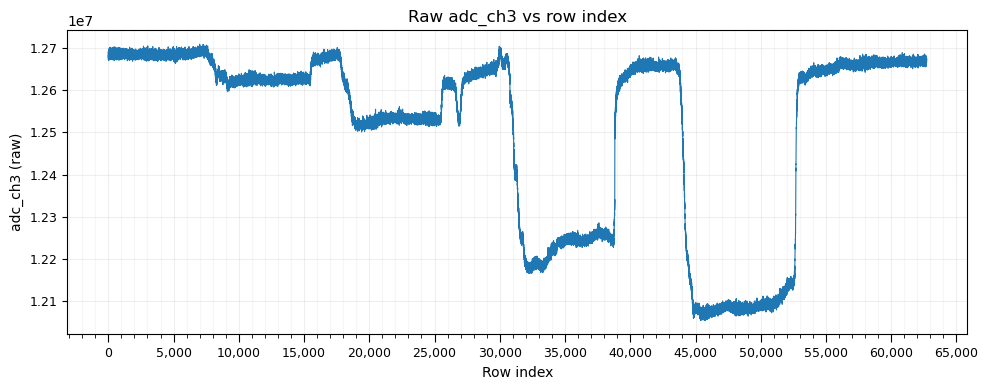

In [6]:
import matplotlib.ticker as mticker

# --- given marker file path (yours) ---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
)

# Derive matching ADC file
adc_path = h_cal_path.replace("data_spacebar_", "data_adc_")

# Load ADC CSV and pull adc_ch3 as a numeric Series
adc_df = pd.read_csv(adc_path)
y_raw = pd.to_numeric(adc_df["adc_ch3"], errors="coerce")

# Optional: downsample for speed if huge (keep every 'step' point)
step = 1  # set to 2/3/... to thin the plot
y_plot = y_raw.iloc[::step].reset_index(drop=True)
x_plot = np.arange(len(y_plot))

# ---- Plot: raw adc_ch3 vs row index with denser ticks ----
plt.figure(figsize=(10, 4))
plt.plot(x_plot, y_plot.values, linewidth=0.8)

ax = plt.gca()

# 1) More major ticks (aim for ~15 labeled ticks)
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15, prune=None))

# 2) Minor ticks between majors (e.g., 5)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))

# 3) Make ticks readable
ax.tick_params(axis="x", which="major", length=6)
ax.tick_params(axis="x", which="minor", length=3)
ax.tick_params(axis="both", which="both", labelsize=9)

# 4) Show thousands separators on x
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))

plt.xlabel("Row index")
plt.ylabel("adc_ch3 (raw)")
plt.title("Raw adc_ch3 vs row index")
plt.grid(alpha=0.2, which="major")
plt.grid(alpha=0.1, which="minor", axis="x")
plt.tight_layout()
plt.show()


Counts per angle:
angle
0.0     500
22.5    500
45.0    500
67.5    500
90.0    500
Name: adc_ch3, dtype: int64

Quadratic fit: ADC = a + b·θ + c·θ²
  a = 1.26937e+07,  b = -1824.06,  c = -57.8007
  R² = 0.982227


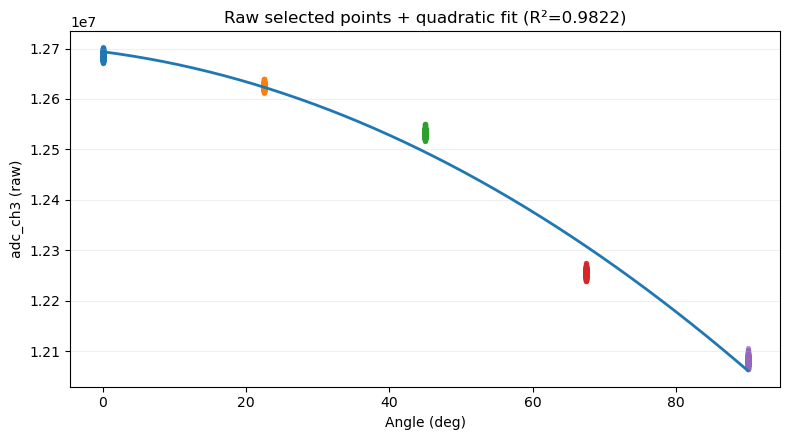

In [7]:
# --- given marker file path (yours) ---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
)

# Derive matching ADC file
adc_path = h_cal_path.replace("data_spacebar_", "data_adc_")

# Load ADC CSV and pull adc_ch3 as a numpy array
adc_df = pd.read_csv(adc_path)
y = pd.to_numeric(adc_df["adc_ch3"], errors="coerce").to_numpy()

# === USER INPUT: five (start_row, end_row) ranges, in order of angles ===
# Example (replace with actual row ranges)
ranges = [
    (  500,  1000),    # 0°
    (13000,  13500),   # 22.5°
    (24000,  24500),   # 45°
    (38000,  38500),   # 67.5°
    (48000,  48500),   # 90°
]

angles = [0.0, 22.5, 45.0, 67.5, 90.0]

# Optional: keep at most N consecutive points per range (set to None for all)
max_points_per_range = None   # e.g., 200

# --- Build the angle→adc DataFrame ---
parts = []
for (start, end), ang in zip(ranges, angles):
    # clamp to valid indices
    start = int(max(0, start))
    end   = int(min(len(y), end))
    if end <= start:
        continue

    vals = y[start:end]
    # drop NaNs if any
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        continue

    if max_points_per_range is not None and vals.size > max_points_per_range:
        # choose the flattest consecutive window of length max_points_per_range
        k = max_points_per_range
        c1 = np.concatenate(([0.0], np.cumsum(vals)))
        c2 = np.concatenate(([0.0], np.cumsum(vals*vals)))
        sum_y  = c1[k:] - c1[:-k]
        sum_y2 = c2[k:] - c2[:-k]
        mean_y = sum_y / k
        var_y  = np.maximum(sum_y2 / k - mean_y**2, 0.0)
        i0 = int(np.argmin(var_y))
        vals = vals[i0:i0+k]

    parts.append(pd.DataFrame({"angle": ang, "adc_ch3": vals}))

angle_adc_df = (pd.concat(parts, ignore_index=True)
                if parts else pd.DataFrame(columns=["angle","adc_ch3"]))

# --- Quick summary ---
print("Counts per angle:")
print(angle_adc_df.groupby("angle")["adc_ch3"].size())

# === Quadratic fit on selected points (ADC = a + b·θ + c·θ²) + R² ===
if not angle_adc_df.empty and angle_adc_df["angle"].nunique() >= 3:
    x_fit = angle_adc_df["angle"].to_numpy(float)
    y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

    # Fit returns [c2, c1, c0] for c2*x^2 + c1*x + c0
    c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)
    y_hat = c0 + c1*x_fit + c2*(x_fit**2)

    ss_res = np.sum((y_fit - y_hat)**2)
    ss_tot = np.sum((y_fit - y_fit.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    print("\nQuadratic fit: ADC = a + b·θ + c·θ²")
    print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
    print(f"  R² = {r2:.6f}")

    # --- Single plot: raw points (vertical bands) + fitted curve ---
    plt.figure(figsize=(8,4.5))
    for ang in angles:
        yy_band = angle_adc_df.loc[angle_adc_df["angle"] == ang, "adc_ch3"].to_numpy()
        if yy_band.size:
            xx_band = np.full_like(yy_band, ang, dtype=float)
            plt.scatter(xx_band, yy_band, s=8, alpha=0.6)

    xx = np.linspace(min(angles), max(angles), 300)
    yy_curve = c0 + c1*xx + c2*(xx**2)
    plt.plot(xx, yy_curve, linewidth=2)

    plt.xlabel("Angle (deg)")
    plt.ylabel("adc_ch3 (raw)")
    plt.title(f"Raw selected points + quadratic fit (R²={r2:.4f})")
    plt.grid(alpha=0.2, axis="y")
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to fit (need points from ≥3 distinct angles).")





Quadratic fit on selected points: ADC = a + b·θ + c·θ²
  a = 1.26937e+07,  b = -1824.06,  c = -57.8007
  R² = 0.982227
Loaded merged_df with 2500 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.6768 in  (95% CI: 0.6645, 0.6890),  R²=0.9761


<function matplotlib.pyplot.show(close=None, block=None)>

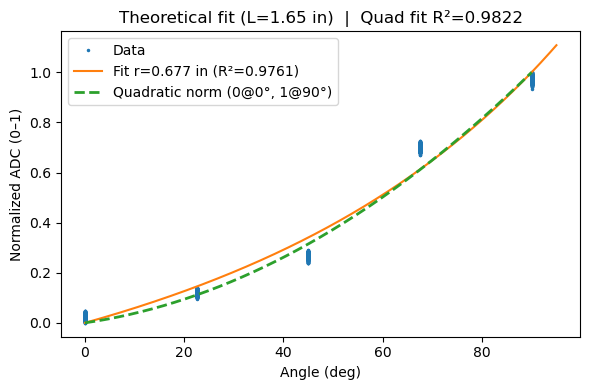

In [8]:


# 1) Quadratic fit on selected raw points: ADC = a + b*θ + c*θ²
x_fit = angle_adc_df["angle"].to_numpy(float)
y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)  # returns [c2, c1, c0]
p = np.poly1d([c2, c1, c0])
y_hat = p(x_fit)

ss_res = np.sum((y_fit - y_hat)**2)
ss_tot = np.sum((y_fit - y_fit.mean())**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("\nQuadratic fit on selected points: ADC = a + b·θ + c·θ²")
print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
print(f"  R² = {r2:.6f}")

# 2) Smooth curve over 0..90 deg
theta_line = np.linspace(0.0, 90.0, 400)
yy_raw = p(theta_line)

# 3) Normalize curve to 0–1 with 0 at 0°, 1 at 90° (auto-flip if needed)
y0, y90 = float(p(0.0)), float(p(90.0))
if y90 >= y0:
    yy_norm = (yy_raw - y0) / max(1e-12, (y90 - y0))
else:
    # ADC decreases with angle → flip so it rises from 0 to 1
    yy_norm = (y0 - yy_raw) / max(1e-12, (y0 - y90))

# --- Now run your class pipeline and overlay on the same axes ---
g = bender_class()
g.load_merged_df(angle_adc_df, enc_col="angle", adc_col="adc_ch3")
g.normalize_adc_bw_01()

# This call presumably creates a plot on current axes:
res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=False)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  "
      f"(95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")

# 4) Overlay the normalized quadratic curve
ax = plt.gca()
ax.plot(theta_line, yy_norm, linestyle="--", linewidth=2,
        label="Quadratic norm (0@0°, 1@90°)")
ax.legend()
ax.set_title(ax.get_title() + f"  |  Quad fit R²={r2:.4f}" if ax.get_title() else f"Quad fit R²={r2:.4f}")
plt.tight_layout()
plt.show




In [60]:


# ============================================================
# A) Existing empirical quadratic fit (unchanged)
# ============================================================
p = np.poly1d([c2, c1, c0])
y0_fit  = float(p(0.0))
y90_fit = float(p(90.0))
increasing_fit = (y90_fit >= y0_fit)

def adc_to_theta_deg(adc_vals, c2, c1, c0,
                     y0=y0_fit, y90=y90_fit,
                     increasing=increasing_fit, clamp=True):
    a = np.asarray(adc_vals, dtype=float)
    theta = np.full_like(a, np.nan, dtype=float)

    if np.isclose(c2, 0.0, atol=1e-14):
        if np.isclose(c1, 0.0, atol=1e-14):
            return theta
        theta = (a - c0) / c1
        return np.clip(theta, 0.0, 90.0) if clamp else theta

    A, B, C = c2, c1, c0 - a
    D = B*B - 4*A*C
    valid = D >= 0
    sqrtD = np.zeros_like(D)
    sqrtD[valid] = np.sqrt(D[valid])
    t1 = np.where(valid, (-B + sqrtD) / (2*A), np.nan)
    t2 = np.where(valid, (-B - sqrtD) / (2*A), np.nan)

    t01 = (a - y0) / (y90 - y0 + 1e-12) if increasing else (y0 - a) / (y0 - y90 + 1e-12)
    t_guess = np.clip(90.0 * t01, 0.0, 90.0)
    d1, d2 = np.abs(t1 - t_guess), np.abs(t2 - t_guess)
    in1 = (t1 >= 0.0) & (t1 <= 90.0)
    in2 = (t2 >= 0.0) & (t2 <= 90.0)

    choose2 = (d2 < d1)
    theta_chosen = np.where(choose2, t2, t1)
    theta_chosen = np.where(in1 & ~choose2, t1, theta_chosen)
    theta_chosen = np.where(in2 &  choose2, t2, theta_chosen)

    return np.clip(theta_chosen, 0.0, 90.0) if clamp else theta_chosen


# ============================================================
# B) Empirical anchors from calibration (unchanged)
# ============================================================
assert {"angle","adc_ch3"}.issubset(angle_adc_df.columns)

EXPECTED = np.array([0.0, 22.5, 45.0, 67.5, 90.0])
def _snap(a):
    a = float(a); j = int(np.argmin(np.abs(EXPECTED - a)))
    return EXPECTED[j] if abs(EXPECTED[j] - a) < 1e-3 else a

cal = angle_adc_df.copy()
cal["angle"] = pd.to_numeric(cal["angle"], errors="coerce").map(_snap)
cal = cal.dropna(subset=["angle","adc_ch3"])

g = cal.groupby("angle")["adc_ch3"]
y0_emp  = float(g.get_group(0.0).mean())
y90_emp = float(g.get_group(90.0).mean())
increasing_emp = (y90_emp >= y0_emp)
den_emp = (y90_emp - y0_emp) if increasing_emp else (y0_emp - y90_emp)
if np.isclose(den_emp, 0.0):
    raise ValueError("Empirical 0°/90° anchors too close; check calibration selections.")

def adc_to_norm_emp(a):
    a = np.asarray(a, float)
    return ((a - y0_emp) / (den_emp + 1e-12)) if increasing_emp else ((y0_emp - a) / (den_emp + 1e-12))


# ============================================================
# C) Timestamp coercion + single-trial processor (timestamp only)
# ============================================================
def _coerce_timestamp_series(df: pd.DataFrame) -> pd.Series:
    """
    Return a best-effort 'timestamp' Series copied from the trial, if present.
    Looks for 'timestamp', 'time', or 'datetime'; otherwise returns NaNs.
    Does not parse/normalize—keeps original representation.
    """
    for col in ["timestamp", "time", "datetime"]:
        if col in df.columns:
            s = df[col].copy()
            s.name = "timestamp"
            return s
    return pd.Series([np.nan]*len(df), name="timestamp")

def trial_adc_to_theta_quad_enriched(trial_df, trial_len_sec=10.0):
    """
    Convert ONE trial to an enriched DataFrame including:
      ['time_s','theta_pred_deg','adc_norm_01','adc_ch3','timestamp']
    """
    if trial_df is None or trial_df.empty:
        return pd.DataFrame(columns=["time_s","theta_pred_deg","adc_norm_01","adc_ch3","timestamp"])

    df = trial_df.copy()
    if "adc_ch3" not in df.columns:
        raise ValueError("Trial is missing 'adc_ch3'.")

    # Keep original timestamp column (raw form)
    ts = _coerce_timestamp_series(df)

    # Build 0..trial_len_sec timebase
    n = len(df)
    time_s = np.linspace(0.0, float(trial_len_sec), n, dtype=float)

    adc_raw  = pd.to_numeric(df["adc_ch3"], errors="coerce").to_numpy()
    adc_norm = np.clip(adc_to_norm_emp(adc_raw), 0.0, 1.0)
    theta_deg = adc_to_theta_deg(adc_raw, c2, c1, c0,
                                 y0=y0_fit, y90=y90_fit,
                                 increasing=increasing_fit,
                                 clamp=True)

    out = pd.DataFrame({
        "time_s": time_s,
        "theta_pred_deg": theta_deg,
        "adc_norm_01": adc_norm,
        "adc_ch3": adc_raw,
        "timestamp": ts.values if len(ts) == n else np.nan
    })
    return out


# ============================================================
# D) Process BOTH sets into ONE tall DataFrame
# ============================================================
def process_trials_to_tall_df(trials, set_label: str, trial_len_sec=10.0):
    """
    trials: list[pd.DataFrame]
    returns one concatenated DataFrame with set/trial columns added.
    """
    pieces = []
    for i, tdf in enumerate(trials, start=1):
        cols = [c for c in ["adc_ch3", "timestamp", "time", "datetime"] if c in tdf.columns]
        tdf_small = tdf[cols].copy() if cols else tdf.copy()
        res = trial_adc_to_theta_quad_enriched(tdf_small, trial_len_sec=trial_len_sec)
        if not res.empty:
            res["trial"] = i
            res["set_label"] = set_label
            pieces.append(res)
    return pd.concat(pieces, ignore_index=True) if pieces else pd.DataFrame(
        columns=["time_s","theta_pred_deg","adc_norm_01","adc_ch3","timestamp","trial","set_label"]
    )

# Example usage:
theta_all_first  = process_trials_to_tall_df(adc_trials_first,  set_label="first",  trial_len_sec=10.0)
theta_all_second = process_trials_to_tall_df(adc_trials_second, set_label="second", trial_len_sec=10.0)
theta_all = pd.concat([theta_all_first, theta_all_second], ignore_index=True)
# print(theta_all.head())


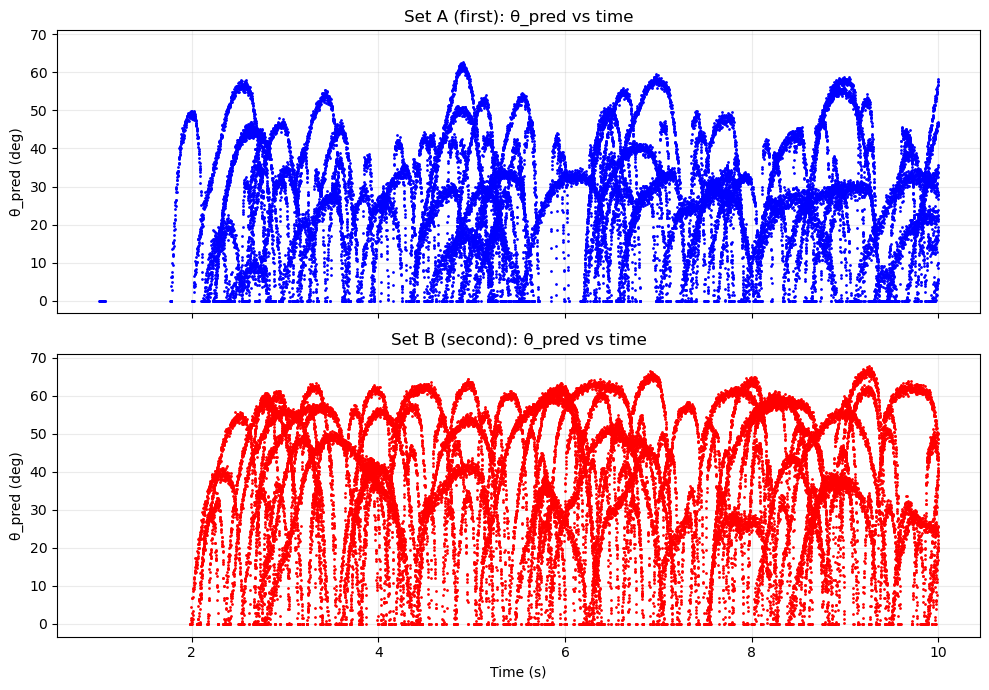

In [66]:
#  Plotting angle vs time 1st application and 1st reapplication data here for strain sensor

# Split by set
A = theta_all[theta_all["set_label"] == "first"]
B = theta_all[theta_all["set_label"] == "second"]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue)
for trial_i in sorted(A["trial"].unique()):
    df = A[A["trial"] == trial_i]
    if not df.empty:
        axes[0].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red)
for trial_i in sorted(B["trial"].unique()):
    df = B[B["trial"] == trial_i]
    if not df.empty:
        axes[1].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


## IMU Analysis of Wrist Bend Angles Here

In [11]:
# --- 1) Extract IMU trials (each is a DataFrame for one trial) ---
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)    # list of length 15
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)   # list of length 15

print(f"First set:  {len(imu_trials_first)} IMU trials")
print(f"Second set: {len(imu_trials_second)} IMU trials")

# --- 2) Access a single trial (e.g., trial 1 from first set) ---
trial1_imu = imu_trials_first[0]   # 0-based index -> trial 1

# Peek columns to see what the IMU file provides
print("Trial 1 IMU columns:", list(trial1_imu.columns))

First set:  15 IMU trials
Second set: 15 IMU trials
Trial 1 IMU columns: ['timestamp', 'adc_ch0', 'adc_ch1', 'adc_ch2', 'adc_ch3', 'application_set', 'trial_index', 'file_index', 'folder_name', 'source_folder', 'source_file', 'source_path', 'timestamp_folder', 'euler1', 'euler2', 'raw', 'volts', 'angle', 'trigger_count']


In [12]:
# --- 1) Extract TRIGGER-TIME trials (each is one CSV grouped by trial) ---
trigger_trials_first  = bb.extract_trigger_dfs_by_trial(df_first)   # list of length ~ n_trials
trigger_trials_second = bb.extract_trigger_dfs_by_trial(df_second)  # list of length ~ n_trials

print(f"First set:  {len(trigger_trials_first)} trigger-time trials")
print(f"Second set: {len(trigger_trials_second)} trigger-time trials")

# --- 2) Access a single trial (e.g., trial 1 from first set) ---
trial1_trigger = trigger_trials_first[0]   # 0-based index -> trial 1
print("Trial 1 trigger-time columns:", list(trial1_trigger.columns))


First set:  15 trigger-time trials
Second set: 15 trigger-time trials
Trial 1 trigger-time columns: ['timestamp', 'adc_ch0', 'adc_ch1', 'adc_ch2', 'adc_ch3', 'application_set', 'trial_index', 'file_index', 'folder_name', 'source_folder', 'source_file', 'source_path', 'timestamp_folder', 'euler1', 'euler2', 'raw', 'volts', 'angle', 'trigger_count']


[A] non-empty trials: 15, rows: 20795
[B] non-empty trials: 15, rows: 20693


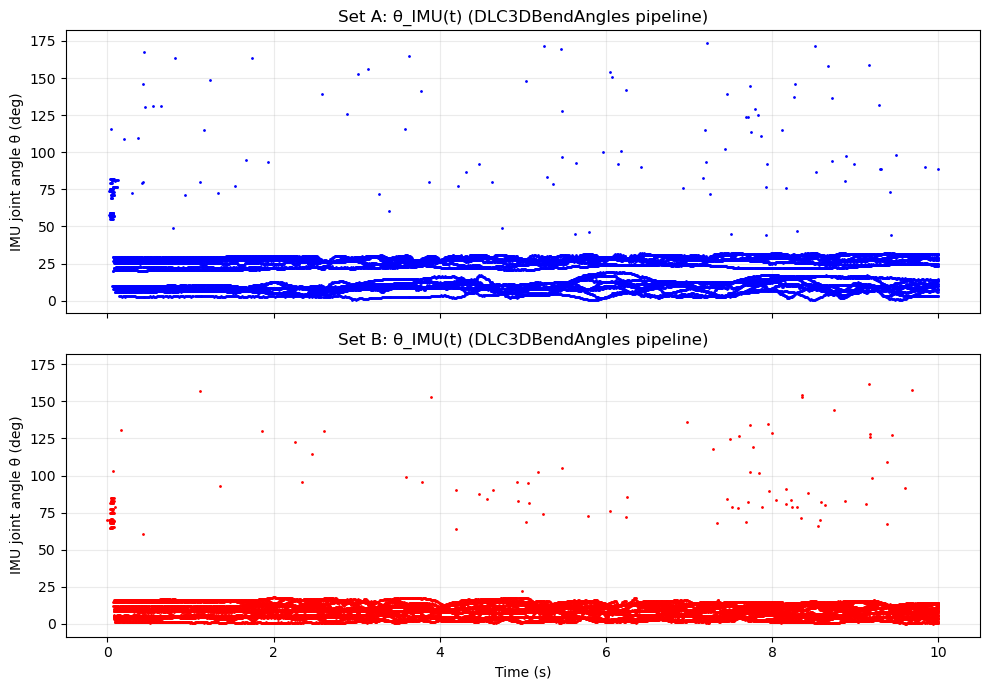

In [52]:
# ---------------------------------------------------------
# 0) Pick any real DLC 3D CSV you already have (content not
#    used here—just needed to construct the class cleanly).
# ---------------------------------------------------------
g = DLC3DBendAngles(trigger_trials_first[0])

# ---------------------------------------------------------
# 2) Helper: clean rows and compute IMU joint angle with class 'g'
# ---------------------------------------------------------
def drop_rows_with_none_in_euler(df, euler_cols=("euler1", "euler2")):
    df = df.copy()
    for c in euler_cols:
        if c not in df.columns:
            raise KeyError(f"Missing expected IMU column: {c}")
        df[c] = df[c].replace(["None", "none", "NULL", "null", ""], np.nan)
    mask_valid = df[list(euler_cols)].notna().all(axis=1)
    return df.loc[mask_valid].copy()

def trial_imu_to_theta_using_g(trial_df, trial_len_sec=10.0):
    """
    Use your DLC3DBendAngles instance 'g' to produce IMU joint angle vs time for ONE trial.
    Returns columns: ['time_s', 'imu_joint_deg_rx_py']  (plus any originals you keep).
    """
    if trial_df.empty:
        return trial_df.copy()

    # 1) Clean
    df = drop_rows_with_none_in_euler(trial_df, euler_cols=("euler1", "euler2"))

    if df.empty:
        return df

    # 2) Attach IMU data to g and run your existing pipeline
    # If you also have encoder columns and normally call load_imu_p_enc(...),
    # you can adapt this step; for pure IMU angle, g.imu_df is sufficient.
    g.imu_df = df.copy()

    # If your raw files already contain Euler angles in 'euler1','euler2',
    # you can still call imu_quat_to_euler to keep the same API; it will
    # just populate the 'imu1_*' and 'imu2_*' fields as your class defines.
    g.imu_quat_to_euler(imu_cols=('euler1','euler2'), out_prefix=('imu1','imu2'))

    # Build unit vectors from Euler (same axes you used before)
    g.euler_to_unit_vec(prefix='imu1', axis='y', out_col='imu1_yvec')
    g.euler_to_unit_vec(prefix='imu2', axis='x', out_col='imu2_xvec')

    # Angle between chosen axes
    g.angle_between_vectors('imu1_yvec', 'imu2_xvec', out_col='imu_joint_deg_rx_py')

    # 3) Build a synthetic 0→trial_len_sec time axis
    n = len(g.imu_df)
    time_s = np.linspace(0.0, float(trial_len_sec), n, dtype=float)

    out = pd.DataFrame({
        "time_s": time_s,
        "imu_joint_deg_rx_py": pd.to_numeric(g.imu_df["imu_joint_deg_rx_py"], errors="coerce")
    })

    return out.dropna(subset=["imu_joint_deg_rx_py"])

def process_trials_with_g(trials, set_label, trial_len_sec=10.0):
    """
    Process a list of trial DataFrames with 'g', preserving 1..15 indexing.
    Returns list of DataFrames (empties kept to keep indexing stable).
    """
    out = []
    for i, t in enumerate(trials, start=1):
        try:
            res = trial_imu_to_theta_using_g(t, trial_len_sec=trial_len_sec)
            if not res.empty:
                res = res.assign(trial=i, set_label=set_label)
            out.append(res)
        except Exception as e:
            print(f"[warn] {set_label} trial {i} skipped: {e}")
            out.append(pd.DataFrame())
    return out

# ---------------------------------------------------------
# 3) Run on both sets
# ---------------------------------------------------------
imu_theta_A = process_trials_with_g(imu_trials_first,  set_label="first",  trial_len_sec=10.0)
imu_theta_B = process_trials_with_g(imu_trials_second, set_label="second", trial_len_sec=10.0)

# Flatten (optional)
A_all = pd.concat([d for d in imu_theta_A if not d.empty], ignore_index=True) if any(not d.empty for d in imu_theta_A) else pd.DataFrame()
B_all = pd.concat([d for d in imu_theta_B if not d.empty], ignore_index=True) if any(not d.empty for d in imu_theta_B) else pd.DataFrame()

print(f"[A] non-empty trials: {sum(1 for d in imu_theta_A if not d.empty)}, rows: {len(A_all)}")
print(f"[B] non-empty trials: {sum(1 for d in imu_theta_B if not d.empty)}, rows: {len(B_all)}")

# ---------------------------------------------------------
# 4) Plot: top (blue = Set A), bottom (red = Set B)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

for df in imu_theta_A:
    if not df.empty:
        axes[0].plot(df["time_s"], df["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title("Set A: θ_IMU(t) (DLC3DBendAngles pipeline)")
axes[0].set_ylabel("IMU joint angle θ (deg)")
axes[0].grid(alpha=0.25)

for df in imu_theta_B:
    if not df.empty:
        axes[1].plot(df["time_s"], df["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title("Set B: θ_IMU(t) (DLC3DBendAngles pipeline)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("IMU joint angle θ (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()
